Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
SEED = 111
#random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [3]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [4]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Наверное, чем больше batch size, тем быстрее обучение, так как за одну эпоху градиенты будут меньше раз обновляться.

Посмотрим на какую-нибудь картинку:

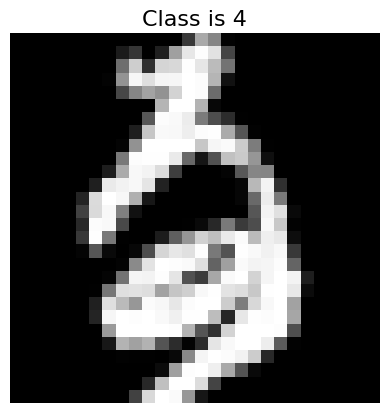

In [5]:
plt.imshow(trainset[4][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[4][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





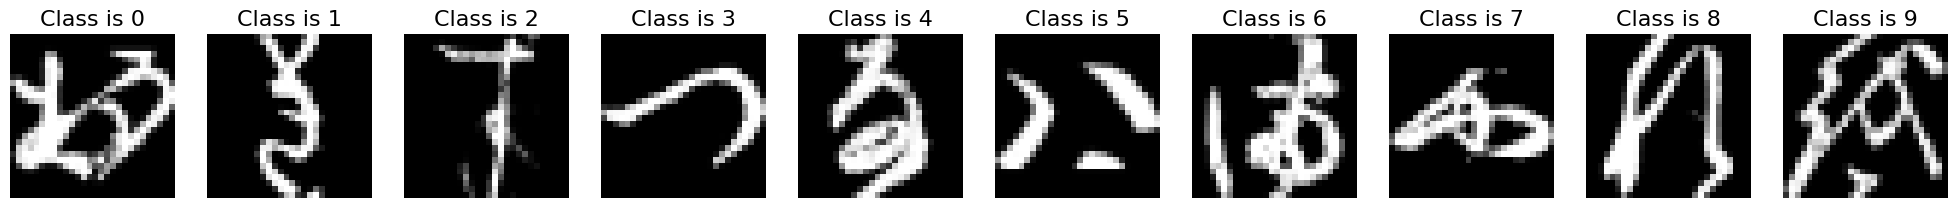

In [6]:
plt.rcParams["figure.figsize"] = (25, 10)

labels = list(range(10))
for i in range(len(trainset)):
    img = trainset[i][0]
    label = trainset[i][1]
    if label in labels:
        plt.subplot(1, 10, label + 1)
        plt.imshow(img.view(28, 28).numpy(), cmap="gray")
        plt.axis("off")
        plt.title(f"Class is {label}", fontsize=16)
        labels.remove(label)
    if labels == []:
        break

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [7]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, activation):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.block = nn.Sequential(
                                   nn.Flatten(),
                                   nn.Linear(28*28, 256),
                                   activation(),
                                   nn.Linear(256, 128),
                                   activation(),
                                   nn.Linear(128, 10)
        )
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.block(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [ ]:
(28 * 28 + 1) * 256 + (256 + 1) * 128 + (128 + 1) *10

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [8]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# # Создадим объект модели
# fc_net = FCNet(n_classes=10)
# # Определим функцию потерь
# loss_function = nn.CrossEntropyLoss()
# # Создадим оптимизатор для нашей сети
# lr = 0.001 # скорость обучения
# optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

# n_epochs = 10
# loss_history = []

# ## YOUR CODE HERE
# for epoch in range(n_epochs):
#     epoch_loss = 0
#     for images, labels in trainloader: # Получаем батч тренировочных картинок
#         optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
#         outputs = fc_net(images) # делаем предсказания
#         loss = loss_function(outputs, labels) # считаем лосс
#         loss.backward() # считаем градиенты
#         optimizer.step() # делаем шаг градиентного спуска

#         epoch_loss += loss.item()

#     loss_history.append(epoch_loss/len(trainloader))

#     print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [9]:
def train_model(model, trainloader, n_epochs, lr, loss_function, 
                optimizer):
    loss_history = []

    loss_function = loss_function()
    optimizer = optimizer(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = model(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


In [10]:
fc_net = FCNet(activation=nn.ReLU)
train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=3e-4, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)

Epoch=1 loss=0.9343
Epoch=2 loss=0.4446
Epoch=3 loss=0.3484
Epoch=4 loss=0.2922
Epoch=5 loss=0.2501
Epoch=6 loss=0.2179
Epoch=7 loss=0.1908
Epoch=8 loss=0.1673
Epoch=9 loss=0.1477
Epoch=10 loss=0.1308


In [12]:
get_accuracy(fc_net, testloader)

0.8679

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [13]:
mean = float((trainset.data / 255).mean())
std = float((trainset.data / 255).std())
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19176216423511505 0.3483428359031677


In [14]:
fc_net = FCNet(activation=nn.ReLU)
train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=3e-4, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)

Epoch=1 loss=0.6916
Epoch=2 loss=0.3071
Epoch=3 loss=0.2279
Epoch=4 loss=0.1780
Epoch=5 loss=0.1424
Epoch=6 loss=0.1154
Epoch=7 loss=0.0939
Epoch=8 loss=0.0767
Epoch=9 loss=0.0623
Epoch=10 loss=0.0505


In [15]:
get_accuracy(fc_net, testloader)

0.8972

Как изменилась `accuracy` после нормализации?

Выросла!

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [16]:
fc_net = FCNet(activation=nn.Sigmoid)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=3e-4, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)


Epoch=1 loss=1.5627
Epoch=2 loss=0.7542
Epoch=3 loss=0.5437
Epoch=4 loss=0.4428
Epoch=5 loss=0.3738
Epoch=6 loss=0.3203
Epoch=7 loss=0.2776
Epoch=8 loss=0.2425
Epoch=9 loss=0.2130
Epoch=10 loss=0.1875


In [17]:
get_accuracy(fc_net, testloader)

0.8562

In [18]:
fc_net = FCNet(activation=nn.GELU)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=3e-4, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)


Epoch=1 loss=0.6688
Epoch=2 loss=0.2821
Epoch=3 loss=0.2039
Epoch=4 loss=0.1557
Epoch=5 loss=0.1227
Epoch=6 loss=0.0980
Epoch=7 loss=0.0782
Epoch=8 loss=0.0623
Epoch=9 loss=0.0502
Epoch=10 loss=0.0397


In [19]:
get_accuracy(fc_net, testloader)

0.9017

In [20]:
fc_net = FCNet(activation=nn.Tanh)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=3e-4, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)

Epoch=1 loss=0.7713
Epoch=2 loss=0.3877
Epoch=3 loss=0.2627
Epoch=4 loss=0.1871
Epoch=5 loss=0.1377
Epoch=6 loss=0.1031
Epoch=7 loss=0.0785
Epoch=8 loss=0.0582
Epoch=9 loss=0.0439
Epoch=10 loss=0.0321


In [21]:
get_accuracy(fc_net, testloader)

0.9063

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

В зависимости от запуска, лучше то ReLU, то GeLU, то Tanh. Сигмоида отстала, конечно..

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

**Adam**

In [32]:
fc_net = FCNet(activation=nn.ReLU)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=1e-3, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)

Epoch=1 loss=0.4529
Epoch=2 loss=0.1864
Epoch=3 loss=0.1221
Epoch=4 loss=0.0826
Epoch=5 loss=0.0583
Epoch=6 loss=0.0402
Epoch=7 loss=0.0277
Epoch=8 loss=0.0205
Epoch=9 loss=0.0169
Epoch=10 loss=0.0121


In [33]:
get_accuracy(fc_net, testloader)

0.8977

**RMSprop**

In [24]:
fc_net = FCNet(activation=nn.ReLU)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=1e-2, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.RMSprop)

Epoch=1 loss=2.4162
Epoch=2 loss=0.2574
Epoch=3 loss=0.2145
Epoch=4 loss=0.2045
Epoch=5 loss=0.1827
Epoch=6 loss=0.1517
Epoch=7 loss=0.1500
Epoch=8 loss=0.1372
Epoch=9 loss=0.1345
Epoch=10 loss=0.1237


In [25]:
get_accuracy(fc_net, testloader)

0.8481

**Adagrad**

In [26]:
fc_net = FCNet(activation=nn.ReLU)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=1e-2, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adagrad)

Epoch=1 loss=0.3636
Epoch=2 loss=0.1563
Epoch=3 loss=0.1093
Epoch=4 loss=0.0824
Epoch=5 loss=0.0640
Epoch=6 loss=0.0508
Epoch=7 loss=0.0405
Epoch=8 loss=0.0327
Epoch=9 loss=0.0266
Epoch=10 loss=0.0217


In [27]:
get_accuracy(fc_net, testloader)

0.9068

Очень зависит от lr... С маленьким lr (3e10-4) лучше всего были Adam и RMSprop. Потом я поставила дефолтный lr для каждого оптимизатора, и лучше всего себя показали Adagrad и Adam... Так что может Adam и правда не плох.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [34]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = (x > 0) * x
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [35]:
fc_net = FCNet(activation=CustomReLU)

train_model(fc_net, trainloader=trainloader, n_epochs=10, lr=3e-4, loss_function=nn.CrossEntropyLoss, 
                optimizer=torch.optim.Adam)

Epoch=1 loss=0.6821
Epoch=2 loss=0.3042
Epoch=3 loss=0.2244
Epoch=4 loss=0.1748
Epoch=5 loss=0.1392
Epoch=6 loss=0.1121
Epoch=7 loss=0.0910
Epoch=8 loss=0.0759
Epoch=9 loss=0.0612
Epoch=10 loss=0.0497


In [36]:
get_accuracy(fc_net, testloader)

0.8992

Я сделаль:)

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Мда...

**Над розовым морем вставала луна, во льду зеленела бутылка вина, и томно кружились влюбленные пары под жалобный рокот гавайской гитары.** 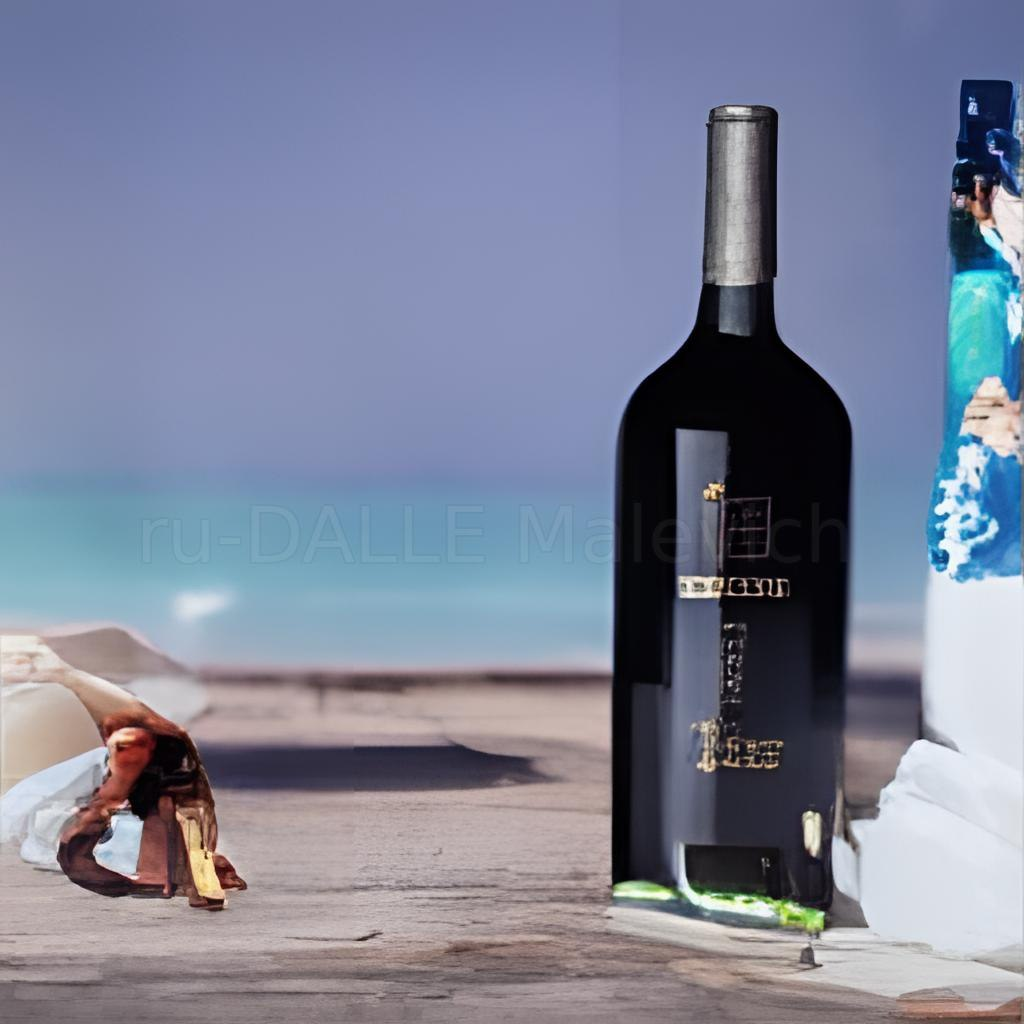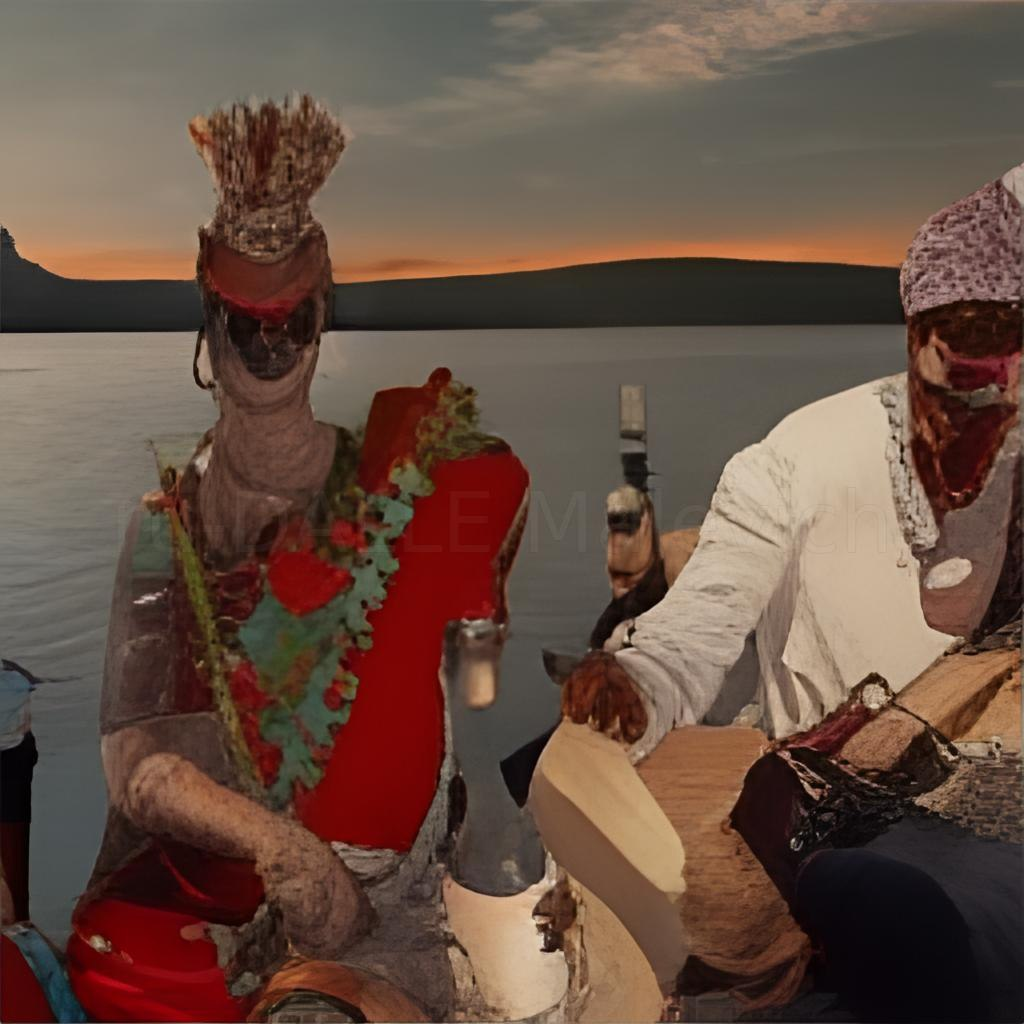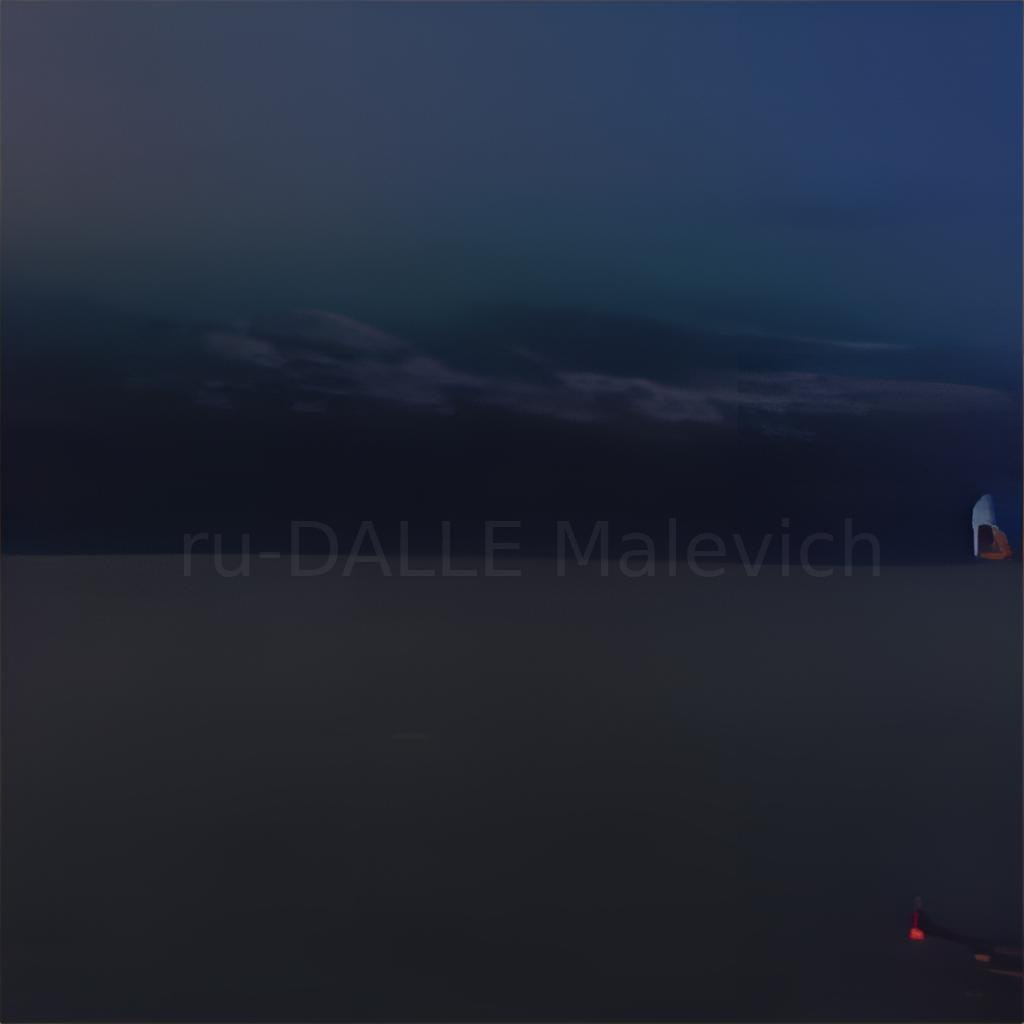

**Армяне играют в нарды.**
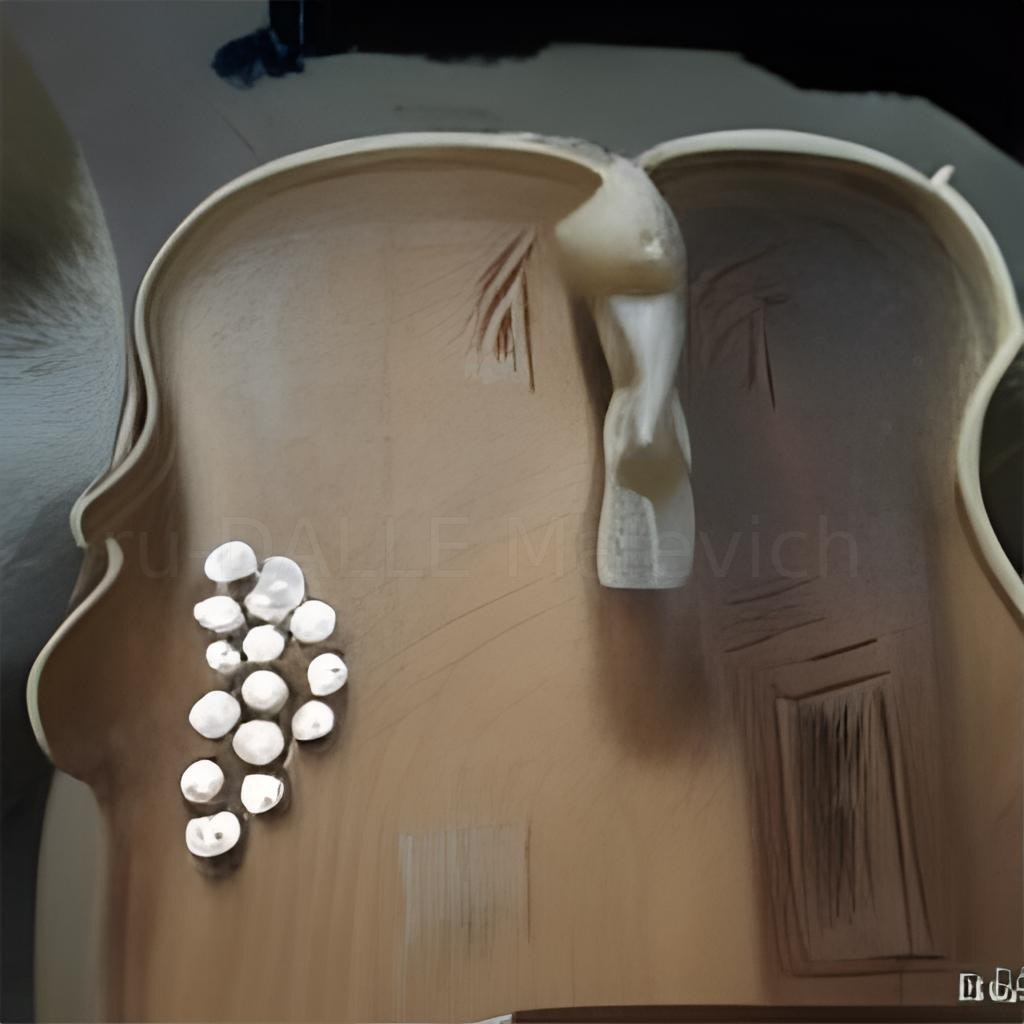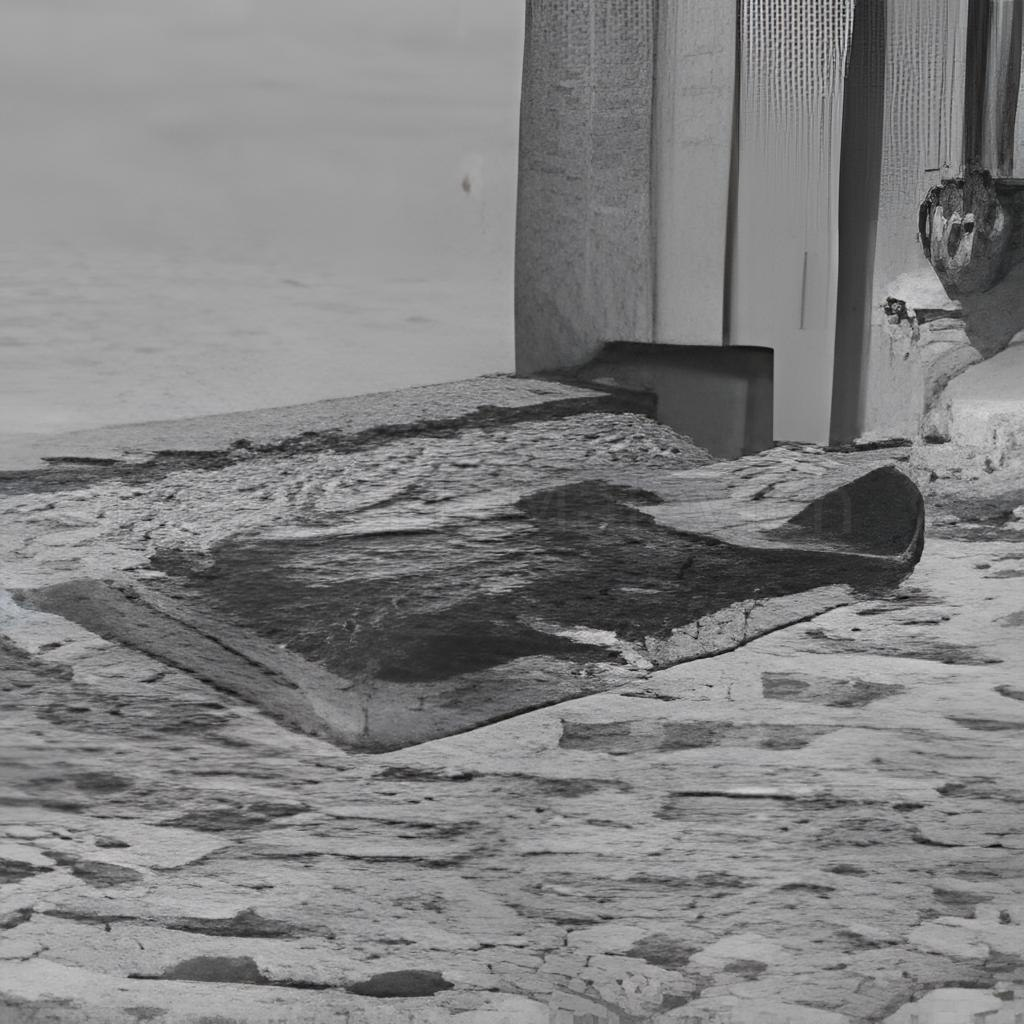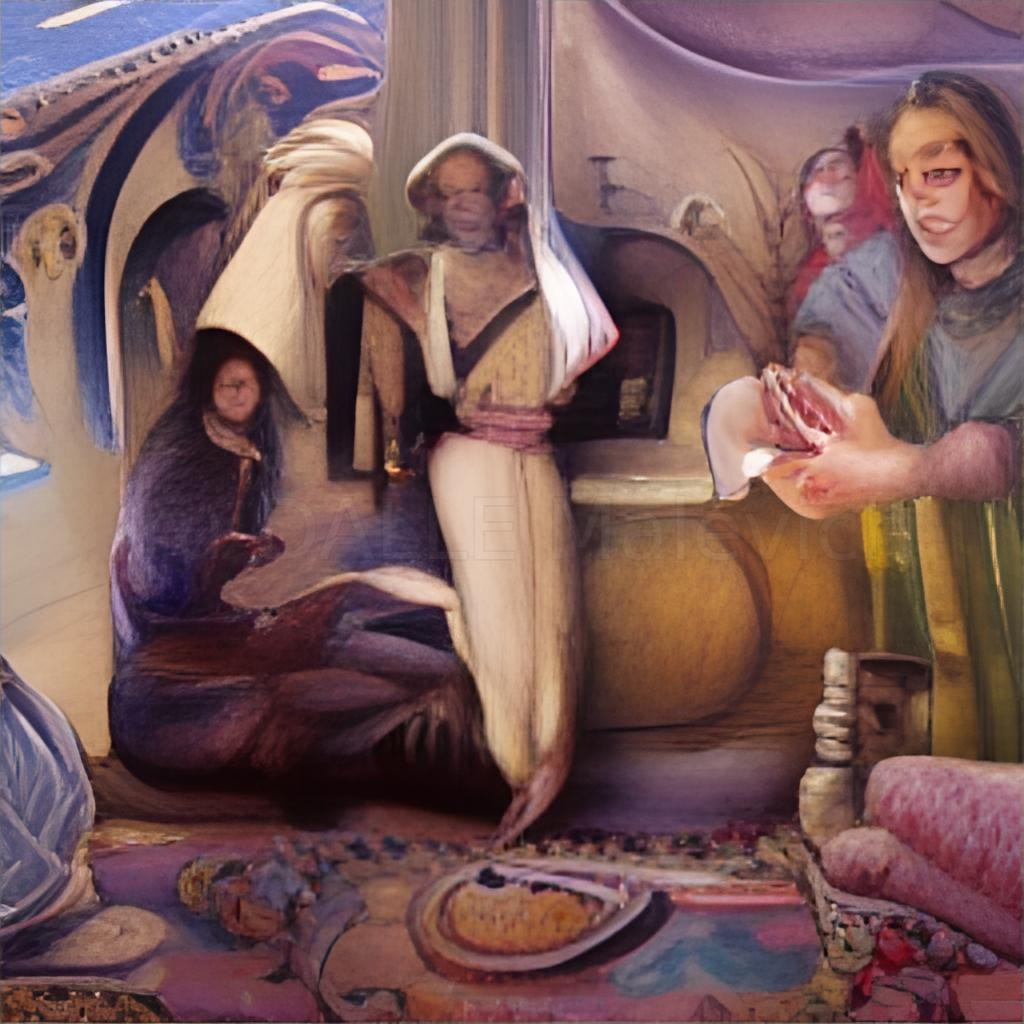

**Самолёт взлетает в небо.**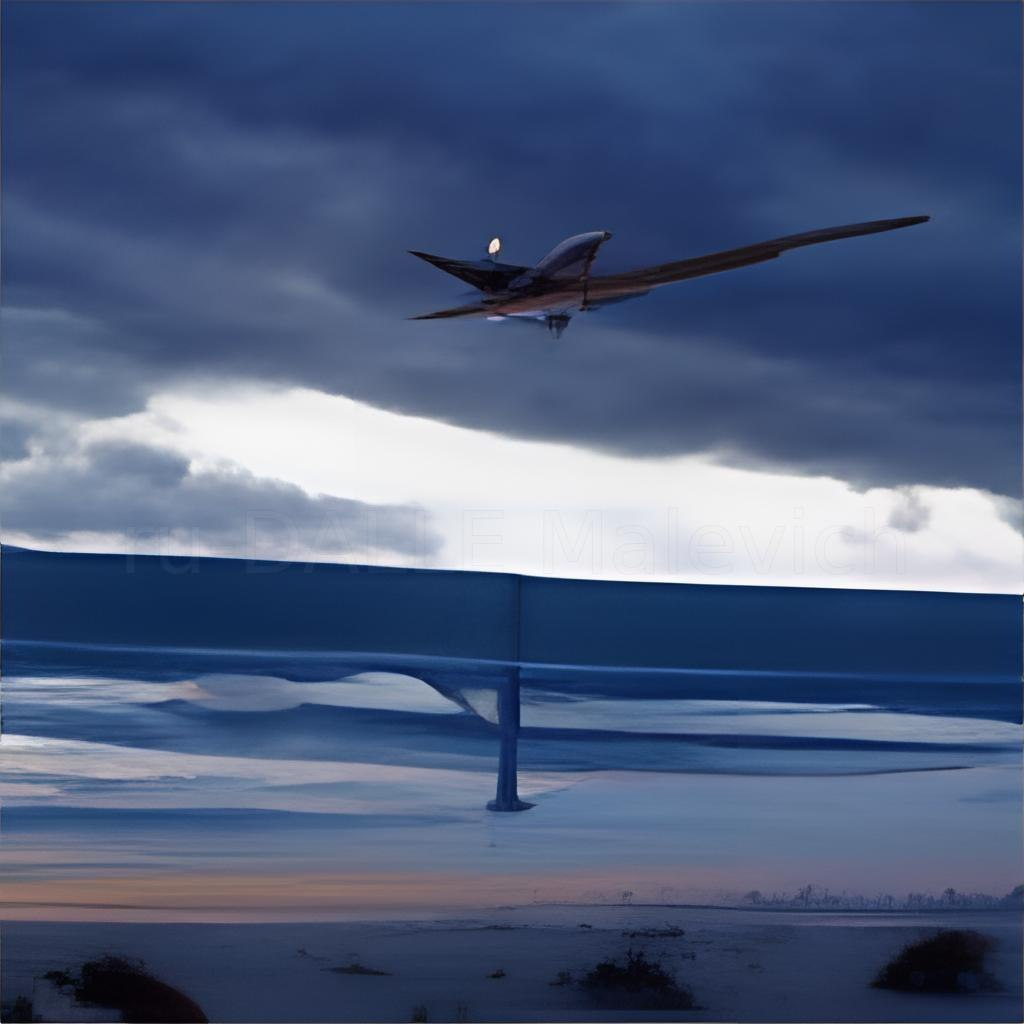